## Heterogeneous
### Author: FENG Zhiqin 3036012011

In [46]:
import numpy as np
import pandas as pd
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

In [47]:
data=pd.read_csv('project_data.csv')

In [48]:
print(data.shape)
data.head()

(1000000, 20)


,user,adid,week,expid,if_click,real_like_cnt,category,brand_effect,experience,status,user_age,friend_age,user_gender,friend_gender,user_city,friend_city,user_degree,friend_degree,user_sns_like_cnt,user_sns_comment_cnt
0,297353,0b0fa14b56d3741178196daaa92e6a1e,w_2,1,0,3,Car,1,1,1,48,37,female,male,level_1,level_1,495,436,162,138
1,98719,ea875acb76e0a806a7837174528f62d9,w_3,1,0,3,Car,1,1,1,29,34,female,female,level_3,level_2,479,3911,212,312
2,205144,1f1fe825014d9e9a0881233d9950bd43,w_2,1,0,1,Jewelry,0,1,1,24,24,female,male,level_2,level_1,682,470,95,336
3,559194,1f1fe825014d9e9a0881233d9950bd43,w_2,1,0,5,Jewelry,0,1,1,26,41,male,male,level_1,level_1,340,602,35,138
4,11888,0d82161270febc99f7defb653e339113,w_3,0,0,1,Cosmetrics,0,1,1,40,34,female,female,level_1,level_2,95,836,50,38


In [49]:
data['category'].value_counts()

Car           200000
Jewelry       200000
Cosmetrics    200000
Beverage      200000
Clothes       200000
Name: category, dtype: int64

In [50]:
# Construct Age Groups:
def get_age(age):
    if age <= 20:
        age_x = '1_20'
    elif age <= 30:
        age_x = '21_30'
    elif age <= 40:
        age_x = '31_40'
    else:
        age_x = '40+'
    return age_x

In [51]:
age_level = data.user_age.apply(get_age).rename('age_level')
friend_age_level = data.friend_age.apply(get_age).rename('friend_age_level')
df = pd.concat([data, age_level,friend_age_level], axis = 1)
df.head()

,user,adid,week,expid,if_click,real_like_cnt,category,brand_effect,experience,status,...,user_gender,friend_gender,user_city,friend_city,user_degree,friend_degree,user_sns_like_cnt,user_sns_comment_cnt,age_level,friend_age_level
0,297353,0b0fa14b56d3741178196daaa92e6a1e,w_2,1,0,3,Car,1,1,1,...,female,male,level_1,level_1,495,436,162,138,40+,31_40
1,98719,ea875acb76e0a806a7837174528f62d9,w_3,1,0,3,Car,1,1,1,...,female,female,level_3,level_2,479,3911,212,312,21_30,31_40
2,205144,1f1fe825014d9e9a0881233d9950bd43,w_2,1,0,1,Jewelry,0,1,1,...,female,male,level_2,level_1,682,470,95,336,21_30,21_30
3,559194,1f1fe825014d9e9a0881233d9950bd43,w_2,1,0,5,Jewelry,0,1,1,...,male,male,level_1,level_1,340,602,35,138,21_30,40+
4,11888,0d82161270febc99f7defb653e339113,w_3,0,0,1,Cosmetrics,0,1,1,...,female,female,level_1,level_2,95,836,50,38,31_40,31_40


In [7]:
# Average treatment-effect of click

#ATE across all the users
d_0 = df[df['expid'] == 0]['if_click']
d_1 = df[df['expid'] == 1]['if_click']
diff = np.mean(d_1) - np.mean(d_0)
print(diff)
cm = sms.CompareMeans(sms.DescrStatsW(d_1), sms.DescrStatsW(d_0))
ttest = cm.ttest_ind(alternative = 'two-sided', usevar = 'unequal') 
ci=cm.tconfint_diff(alternative = 'two-sided', usevar = 'unequal')
print(ttest,ci)  

0.007902000000000006
(15.43059053287648, 1.0340426453487385e-53, 997326.0389910908) (0.006898301912826558, 0.008905698087173454)


The p-value is statistically significant, indicating a notable difference in the click-through rates between the experimental and control groups.

In [8]:
mod = smf.ols(formula='if_click ~ expid', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               if_click   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     238.1
Date:                Thu, 02 Mar 2023   Prob (F-statistic):           1.03e-53
Time:                        20:01:07   Log-Likelihood:                -56554.
No. Observations:             1000000   AIC:                         1.131e+05
Df Residuals:                  999998   BIC:                         1.131e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0666      0.000    183.933      0.0

The treatment effect regression experiment once again confirms a significant difference between the two groups.

### User Gender

In [9]:
# Across genders (user)
gender_list = ['male', 'female']
gender_res = []
for x in gender_list:
    tmp_d_0 = df[(df['expid'] == 0) & (df['user_gender'] == x)]['if_click']
    tmp_d_1 = df[(df['expid'] == 1) & (df['user_gender'] == x)]['if_click']
    tmp_diff = np.mean(tmp_d_1) - np.mean(tmp_d_0)
    tmp_cm = sms.CompareMeans(sms.DescrStatsW(tmp_d_1), sms.DescrStatsW(tmp_d_0))
    tmp_ci = tmp_cm.tconfint_diff(alpha = 0.05, alternative = 'two-sided', usevar = 'unequal')
    gender_res.append([x, tmp_diff, tmp_ci])
print(gender_res) 

[['male', 0.007885571467497618, (0.006466607309882558, 0.009304535625112678)], ['female', 0.00791791097856262, (0.006497980732057981, 0.00933784122506726)]]


[Text(0, 0, 'male'), Text(1, 0, 'female')]

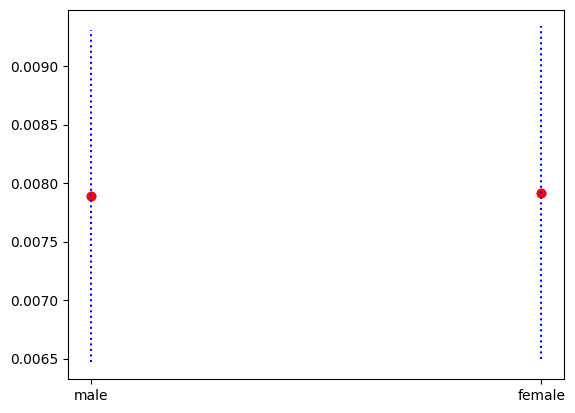

In [10]:
# Plot CATE for males and females
for i in range(len(gender_res)):
    diff = gender_res[i][1]
    ci = gender_res[i][2]
    plt.plot([i, i], [diff, diff], "or")
    plt.plot([i, i], [ci[0], ci[1]], ":b")
f = plt.gca()
f.set_xticks(range(len(gender_res)))
f.set_xticklabels(gender_list)

Both (user) men and women show significant differences (confidence intervals do not include 0), but it is impossible to determine whether men or women have a higher click-through rate because their confidence intervals overlap too much.

### Friend Gender

[['male', 0.0062495186027667765, (0.004833708248123318, 0.007665328957410235)], ['female', 0.00955542314716784, (0.008132347848872516, 0.010978498445463166)]]


[Text(0, 0, 'male'), Text(1, 0, 'female')]

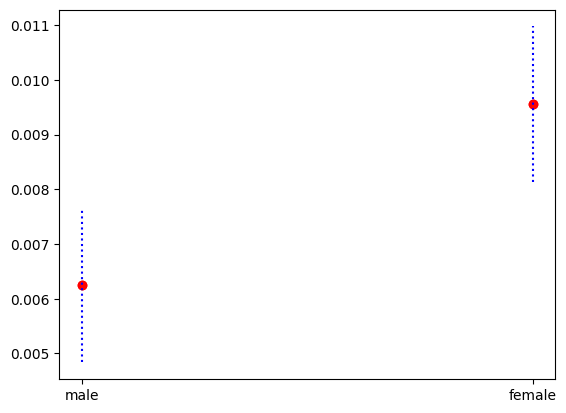

In [11]:
# Across genders (Friend)
gender_list = ['male', 'female']
gender_res = []
for x in gender_list:
    tmp_d_0 = df[(df['expid'] == 0) & (df['friend_gender'] == x)]['if_click']
    tmp_d_1 = df[(df['expid'] == 1) & (df['friend_gender'] == x)]['if_click']
    tmp_diff = np.mean(tmp_d_1) - np.mean(tmp_d_0)
    tmp_cm = sms.CompareMeans(sms.DescrStatsW(tmp_d_1), sms.DescrStatsW(tmp_d_0))
    tmp_ci = tmp_cm.tconfint_diff(alpha = 0.05, alternative = 'two-sided', usevar = 'unequal')
    gender_res.append([x, tmp_diff, tmp_ci])
print(gender_res) 

# Plot CATE for males and females
for i in range(len(gender_res)):
    diff = gender_res[i][1]
    ci = gender_res[i][2]
    plt.plot([i, i], [diff, diff], "or")
    plt.plot([i, i], [ci[0], ci[1]], ":b")
f = plt.gca()
f.set_xticks(range(len(gender_res)))
f.set_xticklabels(gender_list)

In [12]:
df['friend_gender_code'] = df['friend_gender'].replace({'male': 0, 'female': 1})
df.head()

,user,adid,week,expid,if_click,real_like_cnt,category,brand_effect,experience,status,...,friend_gender,user_city,friend_city,user_degree,friend_degree,user_sns_like_cnt,user_sns_comment_cnt,age_level,friend_age_level,friend_gender_code
0,297353,0b0fa14b56d3741178196daaa92e6a1e,w_2,1,0,3,Car,1,1,1,...,male,level_1,level_1,495,436,162,138,40+,31_40,0
1,98719,ea875acb76e0a806a7837174528f62d9,w_3,1,0,3,Car,1,1,1,...,female,level_3,level_2,479,3911,212,312,21_30,31_40,1
2,205144,1f1fe825014d9e9a0881233d9950bd43,w_2,1,0,1,Jewelry,0,1,1,...,male,level_2,level_1,682,470,95,336,21_30,21_30,0
3,559194,1f1fe825014d9e9a0881233d9950bd43,w_2,1,0,5,Jewelry,0,1,1,...,male,level_1,level_1,340,602,35,138,21_30,40+,0
4,11888,0d82161270febc99f7defb653e339113,w_3,0,0,1,Cosmetrics,0,1,1,...,female,level_1,level_2,95,836,50,38,31_40,31_40,1


In [13]:
# Test how friend gender impact the treatment effects
mod_age = smf.ols(formula='if_click ~ friend_gender_code + expid + friend_gender_code*expid', data=df)
res_age = mod_age.fit()
print(res_age.summary())

                            OLS Regression Results                            
Dep. Variable:               if_click   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     83.65
Date:                Thu, 02 Mar 2023   Prob (F-statistic):           4.17e-54
Time:                        20:01:09   Log-Likelihood:                -56548.
No. Observations:             1000000   AIC:                         1.131e+05
Df Residuals:                  999996   BIC:                         1.132e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

The comparison in the graph clearly shows that the mean value for females is significantly higher than that of males, and the confidence intervals for the two do not overlap. Furthermore, the results from OLS indicate that the coefficient for the interaction between friend gender and expid is positive and significant. Both of these findings suggest that when users see a female friend endorsing an ad, they are more likely to click on it compared to seeing a male friend endorse it.

### User Age

In [14]:
#Across age groups
age_list = ['1_20', '21_30', '31_40', '40+']
age_res = []
for x in age_list:
    tmp_d_0 = df[(df['expid'] == 0) & (df['age_level'] == x)]['if_click']
    tmp_d_1 = df[(df['expid'] == 1) & (df['age_level'] == x)]['if_click']
    tmp_diff = np.mean(tmp_d_1) - np.mean(tmp_d_0)
    tmp_cm = sms.CompareMeans(sms.DescrStatsW(tmp_d_1), sms.DescrStatsW(tmp_d_0))
    tmp_ci = tmp_cm.tconfint_diff(alpha = 0.05, alternative = 'two-sided', usevar = 'pooled')
    age_res.append([x, tmp_diff, tmp_ci])
pd.DataFrame(age_res)

,0,1,2
0,1_20,0.008970,"(0.002565032910616708, 0.015374092998158263)"
1,21_30,0.007161,"(0.005492426357648324, 0.008829701892474449)"
2,31_40,0.008112,"(0.006695489144764064, 0.009528958393766686)"
3,40+,0.009053,"(0.00605490895237149, 0.012051784506846791)"


[Text(0, 0, '1_20'),
 Text(1, 0, '21_30'),
 Text(2, 0, '31_40'),
 Text(3, 0, '40+')]

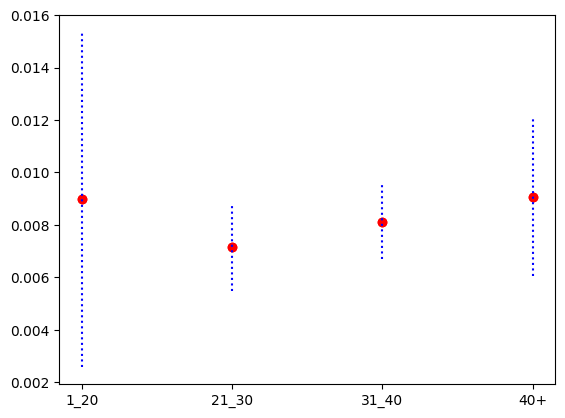

In [15]:
for i in range(len(age_res)):
    diff = age_res[i][1]
    ci = age_res[i][2]
    plt.plot([i, i], [diff, diff], "or")
    plt.plot([i, i], [ci[0], ci[1]], ":b")
f = plt.gca()
f.set_xticks(range(len(age_res)))
f.set_xticklabels(age_list)

In [16]:
# Age is a continous variance - test how age impact the treatment effects
mod_age = smf.ols(formula='if_click ~ user_age + expid + user_age*expid', data=df)
res_age = mod_age.fit()
print(res_age.summary())

                            OLS Regression Results                            
Dep. Variable:               if_click   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     85.85
Date:                Thu, 02 Mar 2023   Prob (F-statistic):           1.54e-55
Time:                        20:01:10   Log-Likelihood:                -56545.
No. Observations:             1000000   AIC:                         1.131e+05
Df Residuals:                  999996   BIC:                         1.131e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0632      0.002     34.

Regardless of the perspective, whether from the overlapping confidence intervals of different age groups in the graph or from the results of OLS analysis showing a p-value greater than 0.05 for the interaction between user_age and expid, it is difficult to claim the existence of differential treatment effects among users of different ages.

### Friend Age

In [17]:
pd.DataFrame(age_res)

,0,1,2
0,1_20,0.008970,"(0.002565032910616708, 0.015374092998158263)"
1,21_30,0.007161,"(0.005492426357648324, 0.008829701892474449)"
2,31_40,0.008112,"(0.006695489144764064, 0.009528958393766686)"
3,40+,0.009053,"(0.00605490895237149, 0.012051784506846791)"


[['1_20', 0.0045923201956011295, (-0.001529833904945664, 0.010714474296147924)], ['21_30', 0.007008543260992775, (0.005391015465986912, 0.008626071055998637)], ['31_40', 0.00885772302561516, (0.00743306212815227, 0.01028238392307805)], ['40+', 0.007421776215641773, (0.004119269017336004, 0.010724283413947542)]]


[Text(0, 0, '1_20'),
 Text(1, 0, '21_30'),
 Text(2, 0, '31_40'),
 Text(3, 0, '40+')]

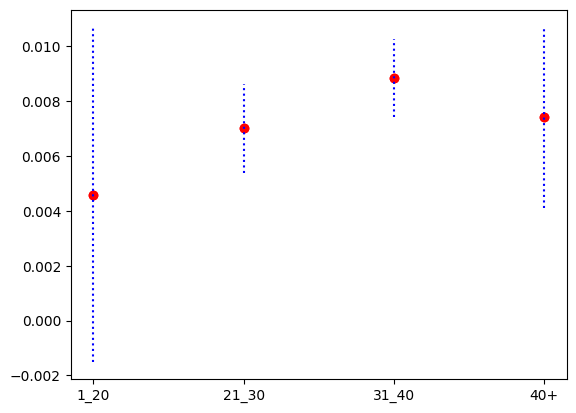

In [18]:
#Across age groups
age_list = ['1_20', '21_30', '31_40', '40+']
age_res = []
for x in age_list:
    tmp_d_0 = df[(df['expid'] == 0) & (df['friend_age_level'] == x)]['if_click']
    tmp_d_1 = df[(df['expid'] == 1) & (df['friend_age_level'] == x)]['if_click']
    tmp_diff = np.mean(tmp_d_1) - np.mean(tmp_d_0)
    tmp_cm = sms.CompareMeans(sms.DescrStatsW(tmp_d_1), sms.DescrStatsW(tmp_d_0))
    tmp_ci = tmp_cm.tconfint_diff(alpha = 0.05, alternative = 'two-sided', usevar = 'unequal')
    age_res.append([x, tmp_diff, tmp_ci])
print(age_res)

for i in range(len(age_res)):
    diff = age_res[i][1]
    ci = age_res[i][2]
    plt.plot([i, i], [diff, diff], "or")
    plt.plot([i, i], [ci[0], ci[1]], ":b")
f = plt.gca()
f.set_xticks(range(len(age_res)))
f.set_xticklabels(age_list)

In [19]:
# Age is a continous variance - test how age impact the treatment effects
mod_age = smf.ols(formula='if_click ~ friend_age_level + expid + friend_age_level*expid', data=df)
res_age = mod_age.fit()
print(res_age.summary())

                            OLS Regression Results                            
Dep. Variable:               if_click   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     42.29
Date:                Thu, 02 Mar 2023   Prob (F-statistic):           4.33e-60
Time:                        20:01:14   Log-Likelihood:                -56525.
No. Observations:             1000000   AIC:                         1.131e+05
Df Residuals:                  999992   BIC:                         1.132e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

Both overlapping confidence intervals and p-values greater than 0.05 in OLS results indicate the promoting effect of friends' likes on users' ad clicks, with no significant difference observed among different age groups of friends.

### Category

[['Car', 0.0072500000000000064, (0.005031230791048167, 0.009468769208951846)], ['Clothes', 0.006879999999999997, (0.004742072729837484, 0.00901792727016251)], ['Jewelry', 0.01064000000000001, (0.00824748655834276, 0.013032513441657262)], ['Beverage', 0.007949999999999999, (0.00574086041043006, 0.010159139589569937)], ['Cosmetrics', 0.006790000000000004, (0.004537361078110759, 0.00904263892188925)]]


[Text(0, 0, 'Car'),
 Text(1, 0, 'Clothes'),
 Text(2, 0, 'Jewelry'),
 Text(3, 0, 'Beverage'),
 Text(4, 0, 'Cosmetrics')]

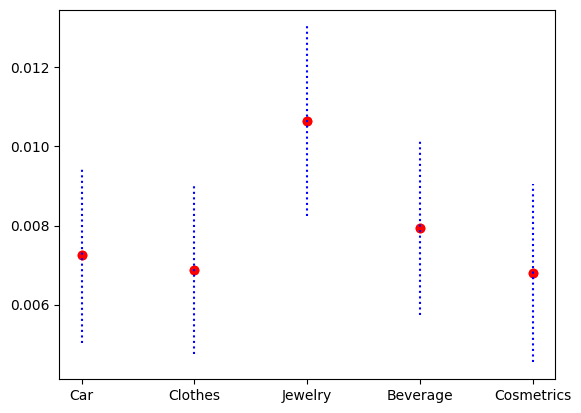

In [26]:
obj='category'
# Across Category
Category_list = list(set(data[obj]))
Category_res = []
for x in Category_list:
    tmp_d_0 = df[(df['expid'] == 0) & (df[obj] == x)]['if_click']
    tmp_d_1 = df[(df['expid'] == 1) & (df[obj] == x)]['if_click']
    tmp_diff = np.mean(tmp_d_1) - np.mean(tmp_d_0)
    tmp_cm = sms.CompareMeans(sms.DescrStatsW(tmp_d_1), sms.DescrStatsW(tmp_d_0))
    tmp_ci = tmp_cm.tconfint_diff(alpha = 0.05, alternative = 'two-sided', usevar = 'unequal')
    Category_res.append([x, tmp_diff, tmp_ci])
print(Category_res) 

# Plot CATE for males and females
for i in range(len(Category_res)):
    diff = Category_res[i][1]
    ci = Category_res[i][2]
    plt.plot([i, i], [diff, diff], "or")
    plt.plot([i, i], [ci[0], ci[1]], ":b")
f = plt.gca()
f.set_xticks(range(len(Category_res)))
f.set_xticklabels(Category_list)

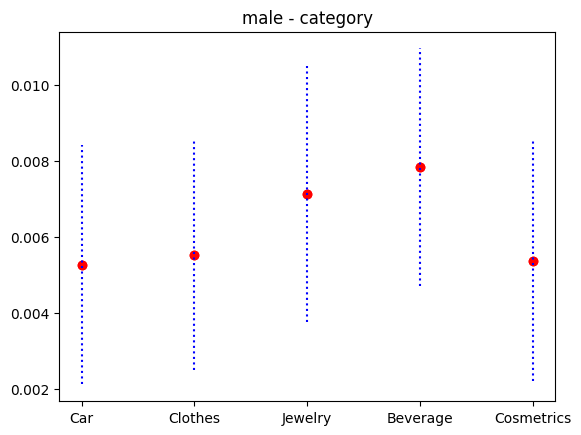

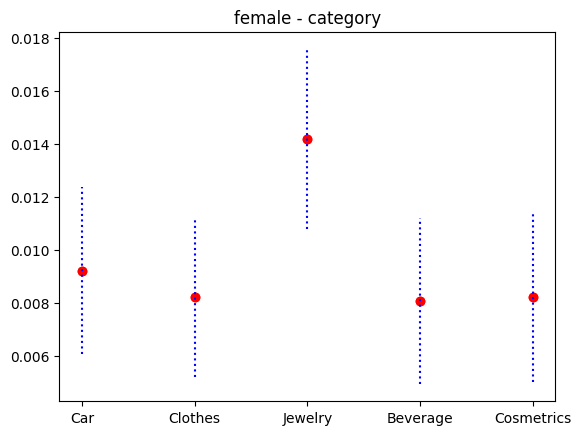

In [73]:
import pandas as pd
import numpy as np
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt

# Loop through unique values in 'category' column
for category in df['friend_gender'].unique():
    # Filter DataFrame for current category
    df2 = df[df['friend_gender'] == category]
    
    # Loop through 'brand_effect' list
    for obj in ['category']:
        # Calculate mean difference and confidence interval for each level of 'brand_effect'
        obj_list = list(set(data[obj]))
        obj_res = []
        for x in obj_list:
            tmp_d_0 = df2[(df2['expid'] == 0) & (df2[obj] == x)]['if_click']
            tmp_d_1 = df2[(df2['expid'] == 1) & (df2[obj] == x)]['if_click']
            tmp_diff = np.mean(tmp_d_1) - np.mean(tmp_d_0)
            tmp_cm = sms.CompareMeans(sms.DescrStatsW(tmp_d_1), sms.DescrStatsW(tmp_d_0))
            tmp_ci = tmp_cm.tconfint_diff(alpha=0.05, alternative='two-sided', usevar='unequal')
            obj_res.append([x, tmp_diff, tmp_ci])
        
        # Plot and save figure for current category and 'brand_effect'
        fig, ax = plt.subplots()
        for i in range(len(obj_res)):
            diff = obj_res[i][1]
            ci = obj_res[i][2]
            ax.plot([i, i], [diff, diff], "or")
            ax.plot([i, i], [ci[0], ci[1]], ":b")
            ax.set_title(f"{category} - {obj}")
            ax.set_xticks(range(len(obj_res)))
            ax.set_xticklabels(obj_list)
plt.show()
#         plt.savefig(f"{category}_{obj}.png")


### Week

In [21]:
pd.DataFrame(Category_res)

,0,1,2
0,Car,0.00725,"(0.005031230791048167, 0.009468769208951846)"
1,Clothes,0.00688,"(0.004742072729837484, 0.00901792727016251)"
2,Jewelry,0.01064,"(0.00824748655834276, 0.013032513441657262)"
3,Beverage,0.00795,"(0.00574086041043006, 0.010159139589569937)"
4,Cosmetrics,0.00679,"(0.004537361078110759, 0.00904263892188925)"


[['w_2', 0.00835657393883718, (0.00644202391560464, 0.01027112396206972)], ['w_1', 0.011503784632675165, (0.008825550499894703, 0.014182018765455627)], ['w_3', 0.006578267485829806, (0.005279684526414409, 0.007876850445245201)]]


[Text(0, 0, 'w_2'), Text(1, 0, 'w_1'), Text(2, 0, 'w_3')]

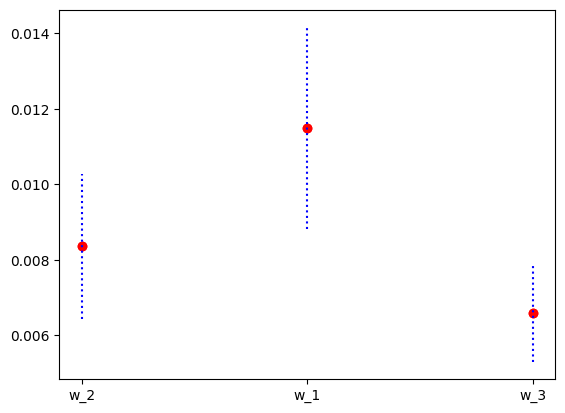

In [22]:
obj='week'
# Across Category
Category_list = list(set(data[obj]))
Category_res = []
for x in Category_list:
    tmp_d_0 = df[(df['expid'] == 0) & (df[obj] == x)]['if_click']
    tmp_d_1 = df[(df['expid'] == 1) & (df[obj] == x)]['if_click']
    tmp_diff = np.mean(tmp_d_1) - np.mean(tmp_d_0)
    tmp_cm = sms.CompareMeans(sms.DescrStatsW(tmp_d_1), sms.DescrStatsW(tmp_d_0))
    tmp_ci = tmp_cm.tconfint_diff(alpha = 0.05, alternative = 'two-sided', usevar = 'unequal')
    Category_res.append([x, tmp_diff, tmp_ci])
print(Category_res) 

# Plot CATE for males and females
for i in range(len(Category_res)):
    diff = Category_res[i][1]
    ci = Category_res[i][2]
    plt.plot([i, i], [diff, diff], "or")
    plt.plot([i, i], [ci[0], ci[1]], ":b")
f = plt.gca()
f.set_xticks(range(len(Category_res)))
f.set_xticklabels(Category_list)

In [23]:
df['week_code'] = df['week'].replace({'w_1': 0, 'w_2': 1, 'w_3': 2})
df.head()

,user,adid,week,expid,if_click,real_like_cnt,category,brand_effect,experience,status,...,user_city,friend_city,user_degree,friend_degree,user_sns_like_cnt,user_sns_comment_cnt,age_level,friend_age_level,friend_gender_code,week_code
0,297353,0b0fa14b56d3741178196daaa92e6a1e,w_2,1,0,3,Car,1,1,1,...,level_1,level_1,495,436,162,138,40+,31_40,0,1
1,98719,ea875acb76e0a806a7837174528f62d9,w_3,1,0,3,Car,1,1,1,...,level_3,level_2,479,3911,212,312,21_30,31_40,1,2
2,205144,1f1fe825014d9e9a0881233d9950bd43,w_2,1,0,1,Jewelry,0,1,1,...,level_2,level_1,682,470,95,336,21_30,21_30,0,1
3,559194,1f1fe825014d9e9a0881233d9950bd43,w_2,1,0,5,Jewelry,0,1,1,...,level_1,level_1,340,602,35,138,21_30,40+,0,1
4,11888,0d82161270febc99f7defb653e339113,w_3,0,0,1,Cosmetrics,0,1,1,...,level_1,level_2,95,836,50,38,31_40,31_40,1,2


In [24]:
# Test how week impact the treatment effects
mod_age = smf.ols(formula='if_click ~ week_code + expid + week_code*expid', data=df)
res_age = mod_age.fit()
print(res_age.summary())

                            OLS Regression Results                            
Dep. Variable:               if_click   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     430.8
Date:                Thu, 02 Mar 2023   Prob (F-statistic):          9.96e-280
Time:                        20:01:17   Log-Likelihood:                -56028.
No. Observations:             1000000   AIC:                         1.121e+05
Df Residuals:                  999996   BIC:                         1.121e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0799      0.001    1

The confidence interval chart reveals that the mean of the first week is higher than that of the third week, and the confidence intervals do not overlap. This demonstrates a significant difference. The OLS results further confirm this observation, as the cross-term coefficient of week_code and expid is negative and statistically significant. These findings collectively suggest that as time progresses, the effect of friends' likes on promoting user clicks on ads becomes increasingly weaker. This observation aligns with common sense, as new features always attract users to experiment but behavior eventually returns to normal once curiosity fades.